In [1]:
import os
import random
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    fig.set_figheight(5)
    fig.set_figwidth(12)
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].axis('off')

In [3]:
def show_slices_seg(slices):
    fig = plt.figure()
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.imshow(slices[0].T, cmap="gray",origin="lower")
    plt.imshow(slices[1].T, cmap="jet",origin="lower",alpha=0.4)
    plt.axis('off')   

In [3]:
# read T1 file data
case1 = nib.load("../train_data/case_1/T1.nii.gz")
case1Data = case1.get_fdata()

In [4]:
case1Data.shape

(128, 144, 128)

Text(0.5, 0.98, 'Center slices for EPI image')

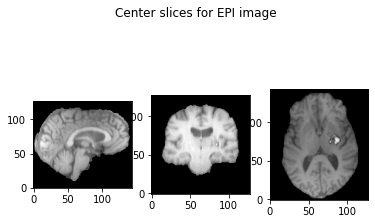

In [5]:
slice_0 = case1Data[64, :, :] # saggital slice
slice_1 = case1Data[:, 72, :] # coronal slice
slice_2 = case1Data[:, :, 64] # axial slice
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image") 

In [6]:
res = resize(case1Data,(128,128,128),order=1,preserve_range=True)

In [7]:
res.shape

(128, 128, 128)

Text(0.5, 0.98, 'Center slices for EPI image')

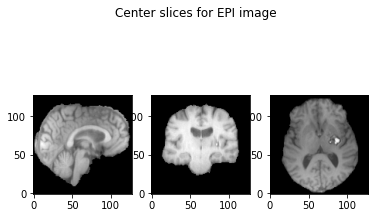

In [8]:
slice_0 = np.expand_dims(res[64, :, :],axis=-1) # saggital slice
slice_1 = np.expand_dims(res[:, 64, :],axis=-1) # coronal slice
slice_2 = np.expand_dims(res[:, :, 64],axis=-1) # axial slice
show_slices([slice_0[:,:,0], slice_1[:,:,0],slice_2[:,:,0]])
plt.suptitle("Center slices for EPI image") 

In [9]:
imgData = nib.load("../train_data/case_1/white_matter.nii.gz").get_fdata()

In [10]:
imgData = resize(imgData,(128,128,128),order=1,preserve_range=True)

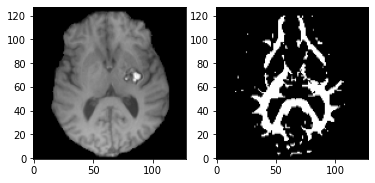

In [11]:
slicewm_0 = np.expand_dims(imgData[64, :, :],axis=-1) # saggital slice
slicewm_1 = np.expand_dims(imgData[:, 64, :],axis=-1) # coronal slice
slicewm_2 = np.expand_dims(imgData[:, :, 64],axis=-1) # axial slice
show_slices([slice_2[:,:,0],slicewm_2[:,:,0]])

## Import training and testing data

In [12]:
imgWidth,imgHeight = 128,128
X_train = np.zeros((20*128*3,128,128,1),dtype=np.uint32)
Y_train = np.zeros((20*128*3,128,128,1),dtype=np.bool)

In [13]:
niiData = []
maskData = []
for i in range(1,21):
    imgData = nib.load("../train_data/case_"+str(i)+"/T1.nii.gz").get_fdata()
    niiData.append(resize(imgData,(128,128,128),order=1,preserve_range=True))
    imgData = nib.load("../train_data/case_"+str(i)+"/white_matter.nii.gz").get_fdata()
    maskData.append(resize(imgData,(128,128,128),order=1,preserve_range=True))

In [15]:
n=0
for i in range(20):
    for j in range(128):
        X_train[n] = np.expand_dims(niiData[i][j,:,:],axis=-1) #saggital slices
        Y_train[n] = np.expand_dims(maskData[i][j,:,:],axis=-1)
        n += 1
        X_train[n] = np.expand_dims(niiData[i][:,j,:],axis=-1) #coronal slices
        Y_train[n] = np.expand_dims(maskData[i][:,j,:],axis=-1)
        n += 1
        X_train[n] = np.expand_dims(niiData[i][:,:,j],axis=-1) #axial slices
        Y_train[n] = np.expand_dims(maskData[i][:,:,j],axis=-1)
        n += 1

In [4]:
testData = []
groundTruth = []
for i in range(21,24):
    imgData = nib.load("../test_data/case_"+str(i)+"/T1.nii.gz").get_fdata()
    testData.append(resize(imgData,(128,128,128),order=1,preserve_range=True))
    imgData = nib.load("../test_data/case_"+str(i)+"/white_matter.nii.gz").get_fdata()
    groundTruth.append(resize(imgData,(128,128,128),order=1,preserve_range=True))

In [5]:
X_test = np.zeros((3*128*3,128,128,1),dtype=np.uint32)
Y_test = np.zeros((3*128*3,128,128,1),dtype=np.uint32)

In [6]:
n=0
for i in range(2):
    for j in range(128):
        X_test[n] = np.expand_dims(testData[i][j,:,:],axis=-1) #saggital slices
        Y_test[n] = np.expand_dims(groundTruth[i][j,:,:],axis=-1)
        n += 1
        X_test[n] = np.expand_dims(testData[i][:,j,:],axis=-1) #coronal slices
        Y_test[n] = np.expand_dims(groundTruth[i][:,j,:],axis=-1)
        n += 1
        X_test[n] = np.expand_dims(testData[i][:,:,j],axis=-1) #axial slices
        Y_test[n] = np.expand_dims(groundTruth[i][:,:,j],axis=-1)
        n += 1

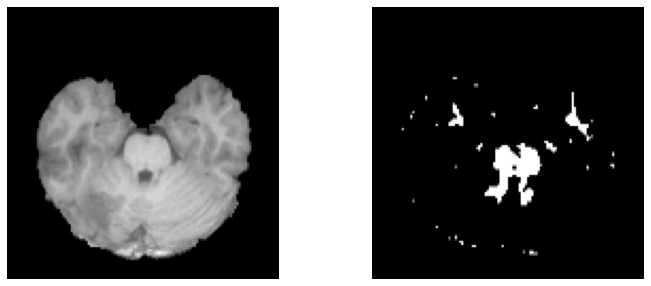

In [7]:
show_slices([X_test[128][:,:,0],Y_test[128][:,:,0]])

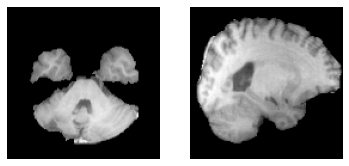

In [23]:
show_slices([X_test[110][:,:,0],X_test[510][:,:,0]])

## U-Net Model

In [20]:
# create model for each mri viewe
# create input layer
inputs = tf.keras.layers.Input((imgWidth,imgHeight,1))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
# encoder layers
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

# decoder layers
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1],axis=3)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

# output layer
outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

#saggital u-net model
model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## Train model

In [21]:
# model checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint('u-net_model.h5',verbose=1,save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='model_logs')
]

In [22]:
# fit model
results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=16,callbacks=callbacks)

Epoch 1/16
432/432 [==============================] - 791s 2s/step - loss: 0.1410 - accuracy: 0.9424 - val_loss: 0.1068 - val_accuracy: 0.9586
Epoch 2/16
432/432 [==============================] - 741s 2s/step - loss: 0.0972 - accuracy: 0.9585 - val_loss: 0.0930 - val_accuracy: 0.9614
Epoch 3/16
432/432 [==============================] - 741s 2s/step - loss: 0.0887 - accuracy: 0.9626 - val_loss: 0.0885 - val_accuracy: 0.9633
Epoch 4/16
432/432 [==============================] - 741s 2s/step - loss: 0.0838 - accuracy: 0.9647 - val_loss: 0.0855 - val_accuracy: 0.9645
Epoch 5/16
432/432 [==============================] - 741s 2s/step - loss: 0.0801 - accuracy: 0.9663 - val_loss: 0.0806 - val_accuracy: 0.9660
Epoch 6/16
432/432 [==============================] - 744s 2s/step - loss: 0.0769 - accuracy: 0.9677 - val_loss: 0.0797 - val_accuracy: 0.9663
Epoch 7/16
432/432 [==============================] - 739s 2s/step - loss: 0.0749 - accuracy: 0.9686 - val_loss: 0.0787 - val_accuracy: 0.9668

In [23]:
results

In [24]:
# save model
model.save('unet_segmentation_model.h5')

## Test model

In [9]:
# load model
model = tf.keras.models.load_model('unet_segmentation_model.h5')

In [65]:
idx = random.randint(0,len(X_train))

In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
preds_test = model.predict(X_test,verbose=1)

In [10]:
prediction = model.predict(X_test,verbose=1)

36/36 [==============================] - 26s 674ms/step


In [11]:
prediction.shape

(1152, 128, 128, 1)

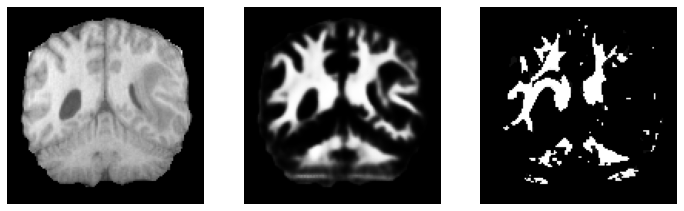

In [12]:
sliIndex = random.randint(0,len(X_test))
show_slices([X_test[sliIndex][:,:,0],prediction[sliIndex][:,:,0],Y_test[sliIndex][:,:,0]])
plt.savefig("../test_data/model_test_"+str(sliIndex)+".png")

## Dice metric

In [13]:
predictionMask = np.where(prediction[sliIndex]>0.12,255,0)

<Figure size 432x288 with 0 Axes>

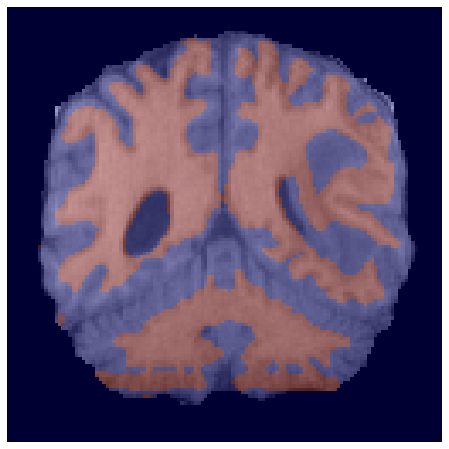

In [14]:
show_slices_seg([X_test[sliIndex][:,:,0],predictionMask[:,:,0]])
plt.savefig("../test_data/model_segment_"+str(sliIndex)+".png")

In [127]:
k=255
gt = Y_test[sliIndex][:,:,0]
seg = predictionMask[:,:,0]
dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))
print('Dice similarity score is {}'.format(dice))

Dice similarity score is 0.45793257394215936


In [30]:
%load_ext tensorboard
%tensorboard --logdir model_logs/

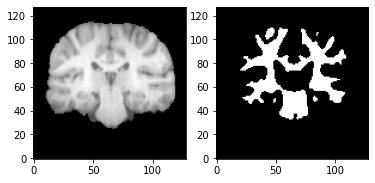

In [70]:
show_slices([X_test[sliIndex][:,:,0],predictionMask[:,:,0]])
plt.savefig("../test_data/PTest_"+str(sliIndex)+".png")

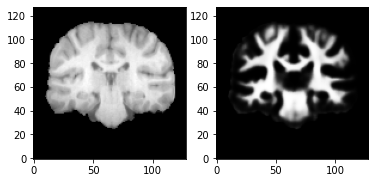

In [71]:
show_slices([X_test[sliIndex][:,:,0],prediction[sliIndex][:,:,0]])
plt.savefig("../test_data/PTest_"+str(sliIndex)+".png")

In [ ]:
TRAIN_DATA = '../test_data/case_1'
 # lee informacion de difusion
diffussionData, affine = load_nifti(TRAIN_DATA+'/Diffusion.nii.gz')
# lee información de vectores para cada voxel
labels = load_nifti_data(TRAIN_DATA+'/brain_mask.nii.gz')
bvals, bvecs = read_bvals_bvecs(TRAIN_DATA+'/Diffusion.bvals', TRAIN_DATA+'/Diffusion.bvecs')
# genera la tabla de gradientes
gtab = gradient_table(bvals, bvecs)
white_matter = (labels == 1) | (labels == 2)
maskData,mask = median_otsu(diffussionData, vol_idx=range(0,9),numpass=1,dilate=5)
# genera modelo de tensores (valores con mayor anisotropia)
dti_model = TensorModel(gtab)
# genera modelo de picos del gradiente
dti_peaks = peaks_from_model(dti_model, maskData, default_sphere,
                     relative_peak_threshold=.75,
                     min_separation_angle=45,
                     mask=white_matter)

# aplica threeshold al resultado del modelo del gradiente para generar una mascara binaria
whiteMatterMask = np.where(dti_peaks.gfa >threshold,255,0)
save_nifti(TRAIN_DATA+'/white_matter.nii.gz',whiteMatterMask,affine)